In [1]:
!rm -rf * .* 2>/dev/null
!rm -rf ~/.kaggle && mkdir ~/.kaggle
!echo eyJ1c2VybmFtZSI6InB2dHNlYzB4MSIsImtleSI6IjZlOTYxZmMxYjdhYzU2OTlmNzcwYmFjMjI1NTk4MWIwIn0= | base64 -d > ~/.kaggle/kaggle.json
!git clone https://github.com/Reshmavineesh/SunLit-Segmentation .
!git checkout dev
!./download_dataset.sh
from IPython.display import clear_output
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'; clear_output()
print("Dataset ready")

Dataset ready


In [2]:
import utils
import tensorflow as tf

image_path = 'dataset/dataset_pistachio_128/color_images/'
mask_path = 'dataset/dataset_pistachio_128/masks/'
n_val = 500

train_images, train_masks, test_images, test_masks = utils.load_dataset(image_path, mask_path, n_val)
print(f"Train Images:\t{train_images.shape}")
print(f"Train Masks:\t{train_masks.shape}")
print(f"Test Images:\t{test_images.shape}")
print(f"Test Masks:\t{test_masks.shape}")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Train Images:	(6850, 128, 128, 3)
Train Masks:	(6850, 128, 128)
Test Images:	(500, 128, 128, 3)
Test Masks:	(500, 128, 128)


In [3]:
from keras_models.models import ResNet101_deeplabV3
from tensorflow.keras.callbacks import EarlyStopping


EPOCHS = 200
LEARNING_RATE = 1e-3
BATCH_SIZE = 10
early_stopper = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
loss=utils.dice_loss
metrics = ['accuracy']
input_shape = train_images.shape[1:]

train_attr = {
    "lr": LEARNING_RATE,
    "batch_size": BATCH_SIZE,
    "optimizer": optimizer.get_config()['name'],
    "loss_fn": loss.get_config()['name']
}

model = ResNet101_deeplabV3(input_shape[0])
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

history = model.fit(train_images,
                    train_masks,
                    validation_split = 0.25,
                    epochs = EPOCHS,
                    batch_size = BATCH_SIZE,
                    callbacks=[early_stopper])

Epoch 1/200
514/514 [==============================] - 74s 71ms/step - loss: 0.4261 - accuracy: 0.8518 - val_loss: 0.4769 - val_accuracy: 0.8505
Epoch 2/200
514/514 [==============================] - 32s 63ms/step - loss: 0.4032 - accuracy: 0.8656 - val_loss: 0.4322 - val_accuracy: 0.9032
Epoch 3/200
514/514 [==============================] - 32s 63ms/step - loss: 0.3972 - accuracy: 0.8691 - val_loss: 0.4621 - val_accuracy: 0.8562
Epoch 4/200
514/514 [==============================] - 32s 63ms/step - loss: 0.3942 - accuracy: 0.8703 - val_loss: 0.4256 - val_accuracy: 0.8968
Epoch 5/200
514/514 [==============================] - 32s 63ms/step - loss: 0.3938 - accuracy: 0.8712 - val_loss: 0.4192 - val_accuracy: 0.9011
Epoch 6/200
514/514 [==============================] - 32s 63ms/step - loss: 0.3878 - accuracy: 0.8735 - val_loss: 0.4276 - val_accuracy: 0.9066
Epoch 7/200
514/514 [==============================] - 32s 63ms/step - loss: 0.3851 - accuracy: 0.8746 - val_loss: 0.4262 - val_ac

1/1 [==============================] - 0s 24ms/step


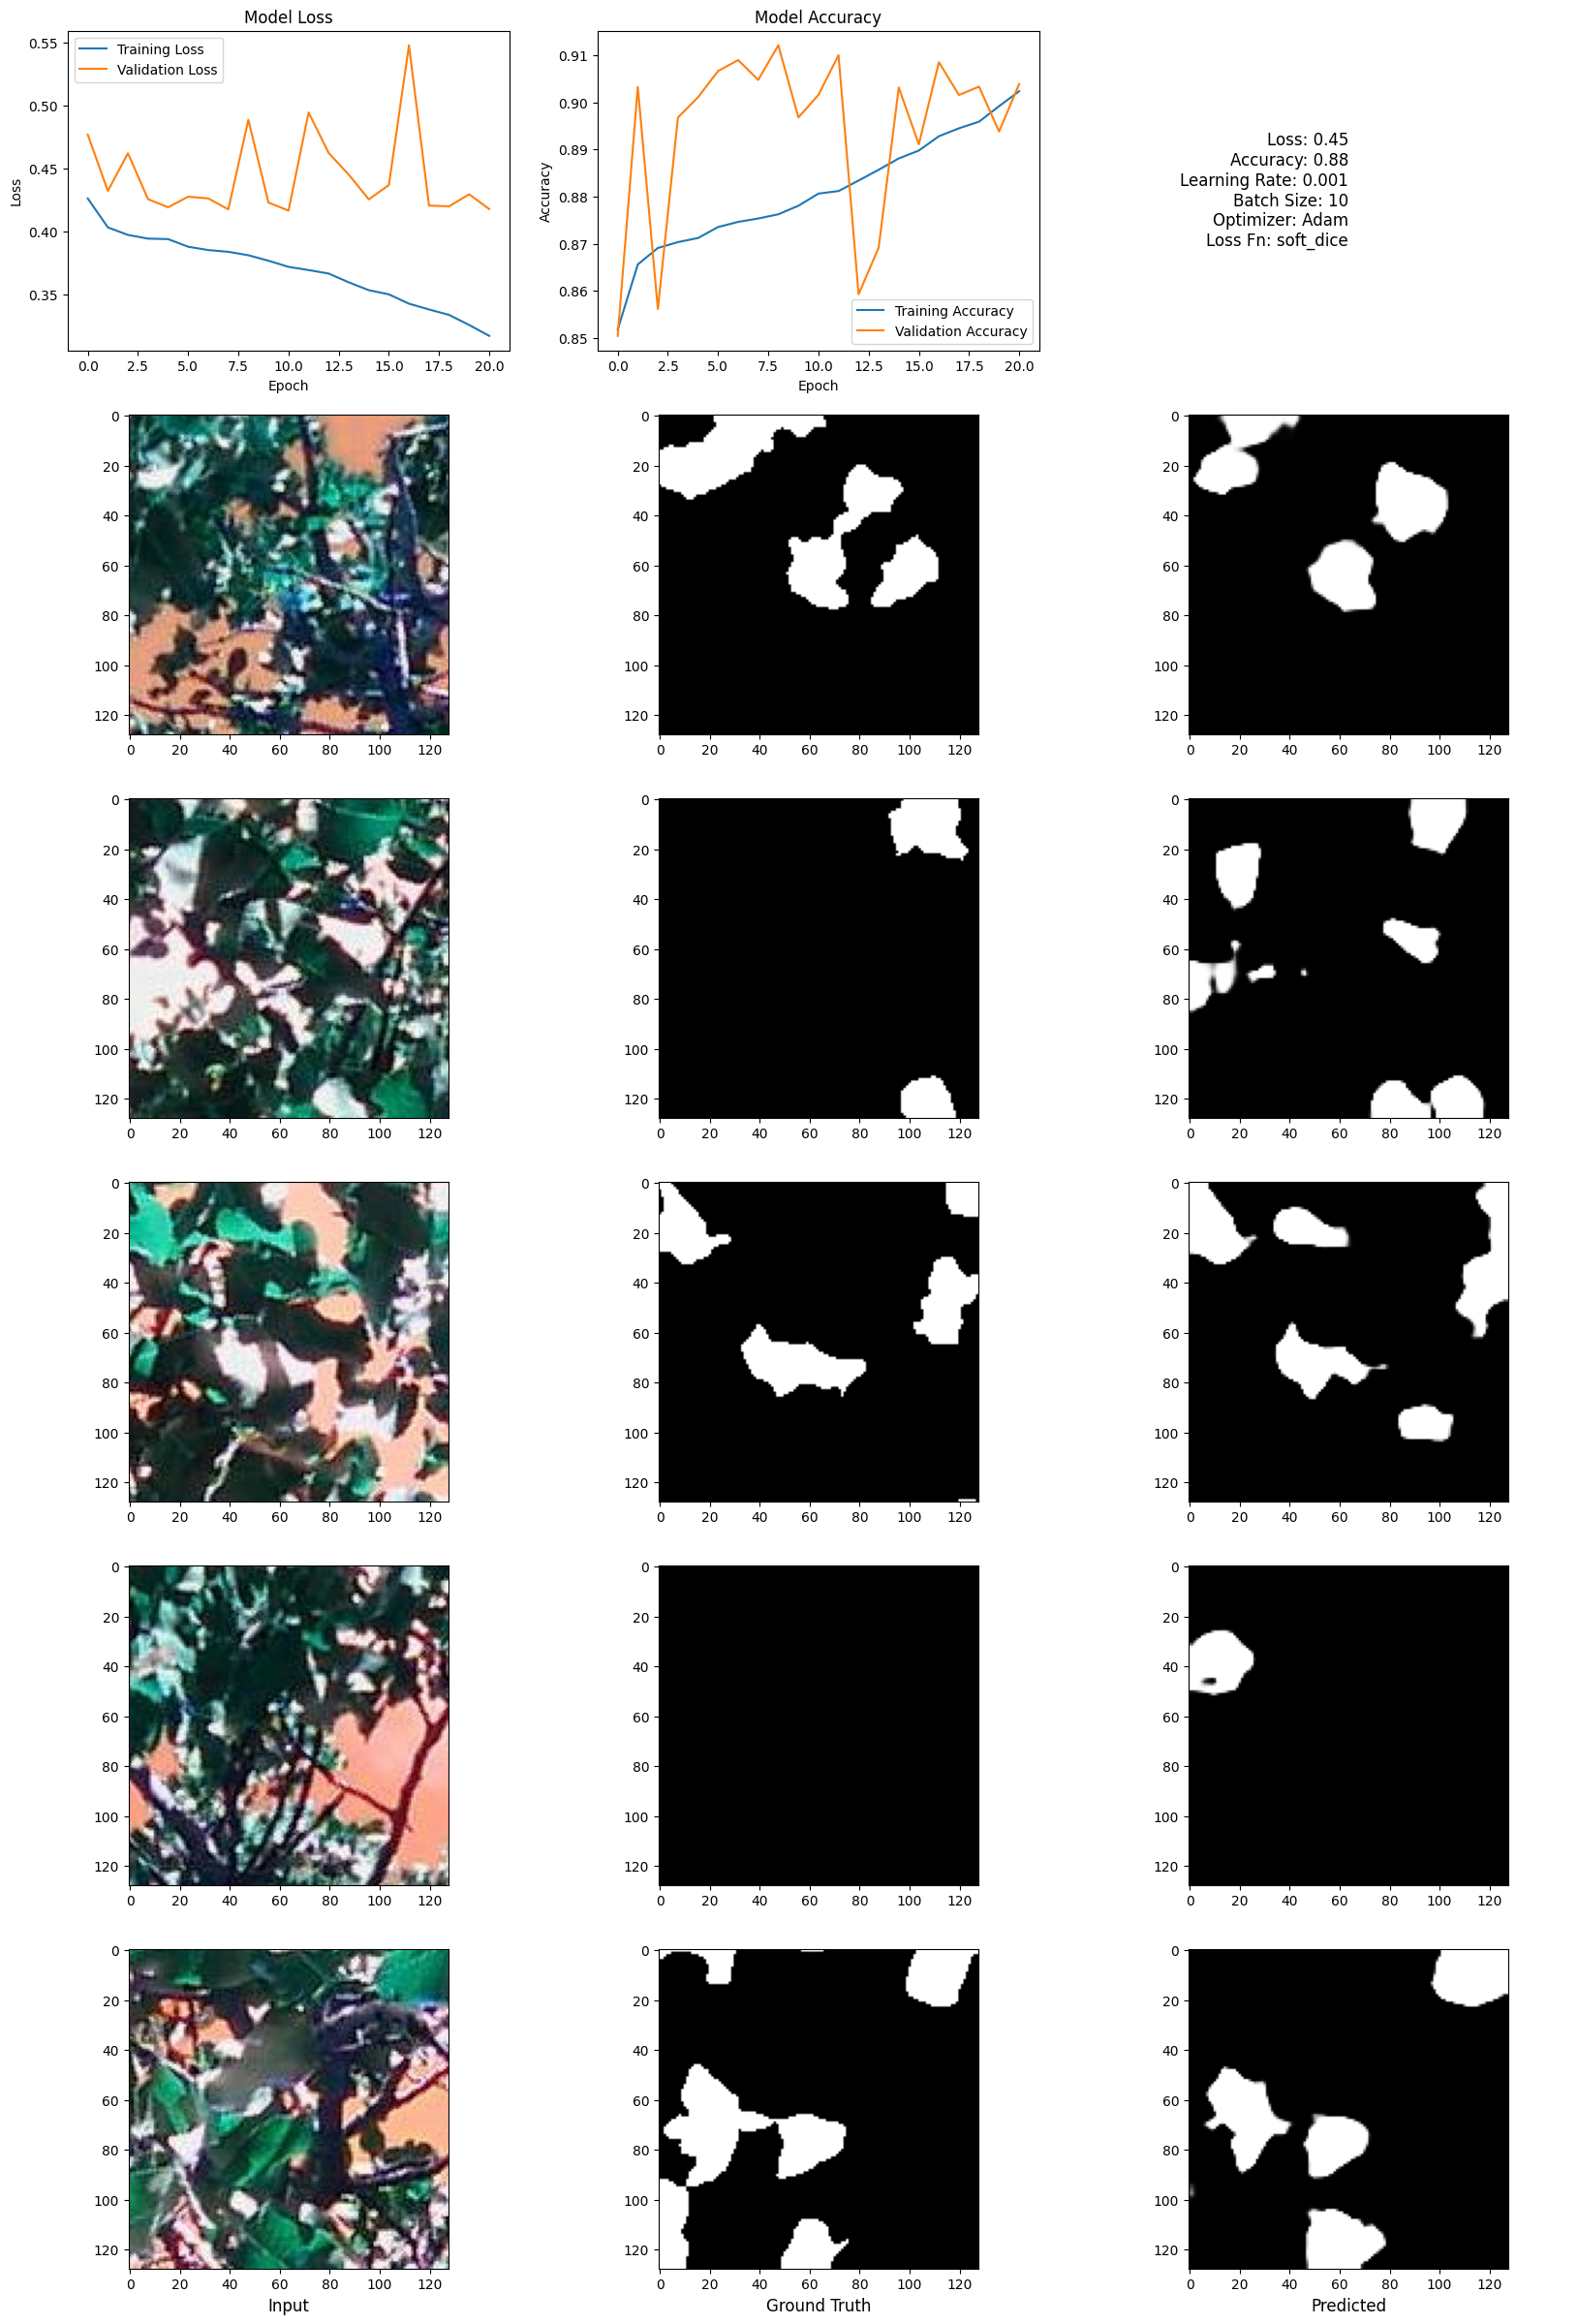

In [4]:
utils.analyzer(history, model, image_path, mask_path, test_images, test_masks, train_attr)